# Create model arquitecture

In [1]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column
import tensorflow as tf

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


%load_ext autoreload
%autoreload 2


In [2]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [3]:
def set_numerical_feature(name):
    
    numerical_feature = feature_column.numeric_column(name, dtype=dtypes.float64)
    
    return numerical_feature
    
def set_one_hot_feature(name, data):
    one_hot_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    one_hot_feature = feature_column.indicator_column(one_hot_feature)
    
    return one_hot_feature

def set_embedding_feature(name, data, dims):
    embedding_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    embedding_feature = feature_column.embedding_column(embedding_feature, dimension=dims)
    
    return embedding_feature

In [4]:
def feature_columns(data, dataset):
    
    feature_columns = []

    # numeric cols
    for header in ['yearOfRegistration', 'powerPS', 'kilometer']:
        feature_columns.append(set_numerical_feature(header))

    feature_columns.append(set_one_hot_feature('abtest', data))
    
    feature_columns.append(set_embedding_feature('vehicleType', data, 5))
    
    feature_columns.append(set_one_hot_feature('gearbox', data))
    
    feature_columns.append(set_one_hot_feature('fuelType', data))
    
    feature_columns.append(set_one_hot_feature('notRepairedDamage', data))
    
    feature_columns.append(set_one_hot_feature('cluster_pcode', data))
    
    feature_columns.append(set_one_hot_feature('cluster_model', data))
    
    feature_columns.append(set_one_hot_feature('cluster_brand', data))
    

    feature_layer = layers.DenseFeatures(feature_columns)
    
    return(feature_layer)

In [5]:
train = preprocessing_fn(path='data/train.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv', brand_clusters='data/brand_clusters.csv', model_clusters='data/model_clusters.csv', postalcode_clusters='data/postalcode_clusters.csv')
val = preprocessing_fn(path='data/val.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv', brand_clusters='data/brand_clusters.csv', model_clusters='data/model_clusters.csv', postalcode_clusters='data/postalcode_clusters.csv')

print(train.shape)
print(val.shape)

(197874, 12)
(49444, 12)


In [6]:
train.dtypes

price                   int64
abtest                 object
vehicleType            object
yearOfRegistration    float32
gearbox                object
powerPS               float32
kilometer             float32
fuelType               object
notRepairedDamage      object
cluster_brand           int32
cluster_model           int32
cluster_pcode           int32
dtype: object

In [7]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=512)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=512)

In [8]:
feature_layer = feature_columns(train, train_ds)

Epoch 1/40
387/387 [==============================] - 15s 39ms/step - loss: 1750.3402 - mean_absolute_error: 1750.3402 - mean_squared_error: 14199230.0000 - val_loss: 1330.7113 - val_mean_absolute_error: 1330.7113 - val_mean_squared_error: 6160239.0000
Epoch 2/40
387/387 [==============================] - 14s 36ms/step - loss: 1295.0359 - mean_absolute_error: 1295.0359 - mean_squared_error: 5616612.0000 - val_loss: 1306.8712 - val_mean_absolute_error: 1306.8712 - val_mean_squared_error: 5849757.5000
Epoch 3/40
387/387 [==============================] - 15s 38ms/step - loss: 1247.4374 - mean_absolute_error: 1247.4374 - mean_squared_error: 5215384.0000 - val_loss: 1296.9121 - val_mean_absolute_error: 1296.9121 - val_mean_squared_error: 5585404.0000
Epoch 4/40
387/387 [==============================] - 11s 29ms/step - loss: 1228.3225 - mean_absolute_error: 1228.3225 - mean_squared_error: 5020020.5000 - val_loss: 1332.9048 - val_mean_absolute_error: 1332.9048 - val_mean_squared_error: 5790

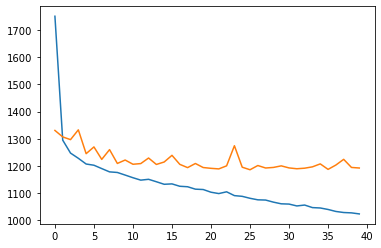

In [9]:
dp_rate = 0.1
lr = 0.001
beta_1 = 0.9
hu = 150

model = keras.Sequential([
    feature_layer,
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(1, activation='relu')
])

# Compile Keras model
model.compile(
    loss='mean_absolute_error',
    metrics=['mean_absolute_error','mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1))

# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)

# get results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.mean_absolute_error)
plt.plot(hist.epoch, hist.val_mean_absolute_error)

In [10]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,1750.340210,1750.340210,14199230.00,1330.711304,1330.711304,6160239.0,0
1,1295.035889,1295.035889,5616612.00,1306.871216,1306.871216,5849757.5,1
2,1247.437378,1247.437378,5215384.00,1296.912109,1296.912109,5585404.0,2
3,1228.322510,1228.322510,5020020.50,1332.904785,1332.904785,5790911.0,3
4,1207.294922,1207.294922,4861611.50,1245.260498,1245.260498,5223697.5,4
5,1202.814453,1202.814453,4802244.50,1270.123657,1270.123657,5334181.0,5
6,1190.500732,1190.500732,4722640.50,1224.300659,1224.300659,5007758.0,6
7,1178.406738,1178.406738,4641424.50,1260.148071,1260.148071,5251603.5,7
8,1176.240967,1176.240967,4595206.50,1209.376099,1209.376099,5018150.5,8
9,1166.676147,1166.676147,4532618.50,1221.957886,1221.957886,5039395.0,9


In [11]:
train_pred = model.predict(df_to_dataset(dataframe=train, target_name='price', shuffle=False, batch_size=1000)).flatten() 

In [12]:
# super baseline model
np.mean(np.abs(train.price - train.price.mean()))

4453.78160169609

In [13]:
# my model
np.mean(np.abs(train.price - train_pred))

993.8074904024581

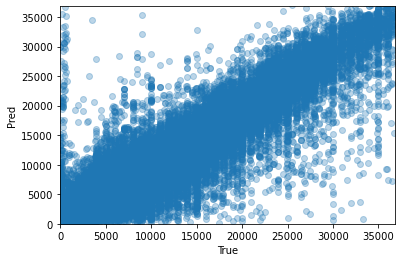

In [15]:
plt.scatter(train.price, train_pred, alpha=0.3)
plt.xlim([0, train.price.max()])
plt.ylim([0, train.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

In [16]:
train['price_pred'] = train_pred
train['abs_error'] = abs(train.price_pred - train.price)
train['error'] = train.price_pred - train.price

worst_predictions = train.copy().loc[train.abs_error >= train.abs_error.quantile(0.9)]

In [17]:
# r squared
ss_res = np.sum((train.price - train.price_pred)**2)
ss_tot = np.sum((train.price - np.mean(train.price))**2)
r2 = 1 - ss_res/ss_tot
r2

0.9108533452213595

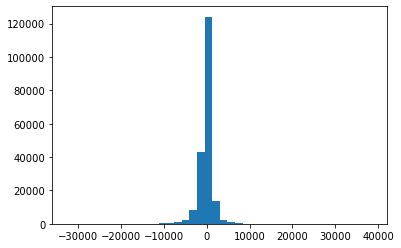

In [18]:
plt.hist(train.error, bins=40)
plt.show()

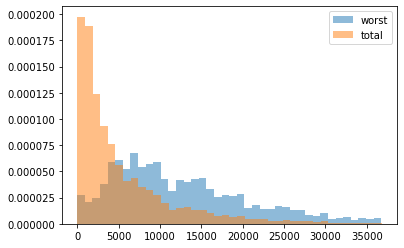

In [19]:
plt.hist(worst_predictions.price, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(train.price, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

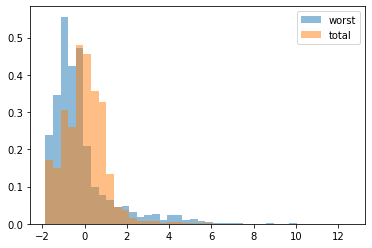

In [20]:
plt.hist(worst_predictions.yearOfRegistration, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(train.yearOfRegistration, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

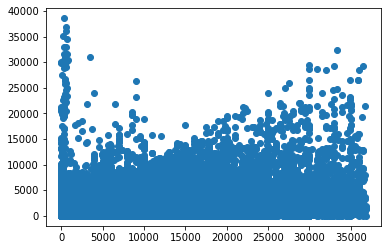

In [21]:
plt.scatter(train.price, train.abs_error)
plt.show()

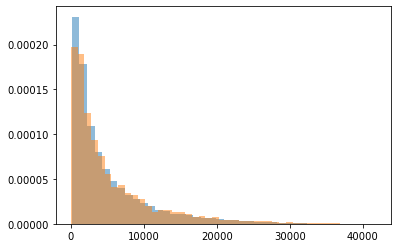

In [45]:
plt.hist(train.price_pred, bins=40, alpha=0.5, density=True)
plt.hist(train.price, bins=40, alpha=0.5, density=True)
plt.show()

In [46]:
i = 9000
print(train.price[i])
print(train.price_pred[i])

4500
1981.3966


In [84]:
train.price.mean()

3140.270146492555